In [62]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math

# Loading data
#data = np.load('data2D.npy')
data = np.load('data100D.npy')
[num_pts, dim] = np.shape(data)

# For Validation set
is_valid = True
if is_valid:
  valid_batch = int(num_pts / 3.0)
  np.random.seed(45689)
  rnd_idx = np.arange(num_pts)
  np.random.shuffle(rnd_idx)
  val_data = data[rnd_idx[:valid_batch]]
  data = data[rnd_idx[valid_batch:]]


# Distance function for K-means, independent test passed
def distance_func(X, mu):
    """ Inputs:
          X: is an NxD matrix (N observations and D dimensions)
          mu: is an KxD matrix (K means and D dimensions)
          
        Output:
          pair_dist: is the squared pairwise distance matrix (NxK)
    """
    if tf.shape(X)[1] == 2: dmu = tf.cast(mu, tf.double)
    else: dmu = mu

    pair_dist = tf.expand_dims(X, axis=1)
    pair_dist = (pair_dist - dmu) ** 2
    pair_dist = tf.reduce_sum(pair_dist, -1)

    return pair_dist

In [51]:
def reduce_logsumexp(input_tensor, reduction_indices=1, keep_dims=False):
  """Computes the sum of elements across dimensions of a tensor in log domain.

     It uses a similar API to tf.reduce_sum.

  Args:
    input_tensor: The tensor to reduce. Should have numeric type.
    reduction_indices: The dimensions to reduce. 
    keep_dims: If true, retains reduced dimensions with length 1.
  Returns:
    The reduced tensor.
  """
  max_input_tensor1 = tf.reduce_max(
      input_tensor, reduction_indices, keepdims=keep_dims)
  max_input_tensor2 = max_input_tensor1
  if not keep_dims:
    max_input_tensor2 = tf.expand_dims(max_input_tensor2, reduction_indices)
  return tf.math.log(
      tf.reduce_sum(
          tf.exp(input_tensor - max_input_tensor2),
          reduction_indices,
          keepdims=keep_dims)) + max_input_tensor1


def logsoftmax(input_tensor):
  """Computes normal softmax nonlinearity in log domain.

     It can be used to normalize log probability.
     The softmax is always computed along the second dimension of the input Tensor.     

  Args:
    input_tensor: Unnormalized log probability.
  Returns:
    normalized log probability.
  """
  return input_tensor - reduce_logsumexp(input_tensor, reduction_indices=0, keep_dims=True)

def scatter_plot(data, k, mu, pi, assignment, valLoss):

  # define a list of colours
  colorList = ['b', 'g', 'c', 'm', 'y']
  
  # plot different cluster assignment iteratively with probability and colour
  plt.figure()
  for _k in range(k):
    x_cluster = data[assignment==_k, :]
    plt.scatter(x_cluster[:, 0], x_cluster[:, 1], s=1, c=colorList[_k], label=f'{pi[_k]:.2f}')

  plt.legend()

  # plot cluster centers
  plt.scatter(mu[:, 0], mu[:, 1], s=30, c='red')

  # print validation loss
  txt = 'validation loss: ' + str(valLoss.numpy())
  plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)

  return

# loss plotter
def plot_loss(lossList):

  plt.figure()
  plt.plot(lossList, label='Training Loss')
  title = "Traing Loss vs iteration"
  plt.title(title)
  plt.xlabel("iterations")
  plt.ylabel("loss")
  plt.legend()
  plt.draw()

  return

In [49]:

# calculate log normal distributions for all data and clusters,
# Args: data [N*D], center [K*D], variance [K]
# Returns: log probability [N*K]
def log_gauss_pdf(X, mu, sigma, dim):
  # taking the log of the distribution, probability is in two terms: coef and exp
  # steps in report
  dist = distance_func(X, mu)
  dist = tf.cast(dist, tf.float32)
  exp = - dist / 2 / sigma

  coef = - (tf.math.log(2 * math.pi * sigma)) * dim / 2

  return exp + coef

# this is the log_posterior function, I just name it differently
# calculate the log probability of cluster given data
# Args: data [N*D], weight [K]
# Returns: log probability [N*K]

def log_posterior(log_pdf, log_pi):

  logWeightedProb = log_pdf + log_pi
  logSum = reduce_logsumexp(logWeightedProb, reduction_indices=1, keep_dims=True)
  return logWeightedProb - logSum

def loss(X, mu, log_sigma, dim, psi):

  sigma = tf.exp(log_sigma)
  log_pi = logsoftmax(psi)  
  logWeightedProb = log_gauss_pdf(X, mu, sigma, dim) + log_pi
  logSum = -reduce_logsumexp(logWeightedProb, reduction_indices=1, keep_dims=True)

  return tf.reduce_sum(logSum)

def train(k, X, dim, val_data):
  # init container for loss
  lossList = []

  # calculate dataset mean and var
  mean = tf.reduce_mean(X).numpy()
  var = (tf.math.reduce_std(X) ** 2).numpy()

  # init mu, sigma, pi
  mu = tf.Variable(tf.random.normal((k, dim), mean, var))
  sigma = tf.ones([k]) * var
  log_sigma = tf.math.log(sigma)
  log_sigma = tf.Variable(log_sigma)
  psi = tf.Variable(tf.random.normal((k, ), 0, 1))
  

  # init optimizer
  optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=0.1, beta1=0.9, beta2=0.99, epsilon=1e-5)

  # train loss
  l = lambda: loss(X, mu, log_sigma, dim, psi)
  for i in range(200):
    optimizer.minimize(l, var_list=[mu, log_sigma, psi])
    lossList.append(loss(X, mu, log_sigma, dim, psi))
  

  ''' this also works but runs slower
  # start gradient descent
  for i in range(200):
    with tf.GradientTape() as g:
      g.watch(mu)
      g.watch(log_sigma)
      g.watch(psi)
      l = loss(X, mu, log_sigma, dim, psi)
    grad = g.gradient(l, [mu, log_sigma, psi])
    optimizer.apply_gradients(zip(grad, [mu, log_sigma, psi]))
    lossList.append(l)
  '''
  

  log_pi = logsoftmax(psi)
  sigma = tf.exp(log_sigma)
  log_pdf = log_gauss_pdf(X, mu, sigma, dim)
  assignment = tf.argmax(log_posterior(log_pdf, log_pi), axis=1)
  pi = tf.exp(log_pi)
  print(mu)
  print(sigma)
  print(pi)

  #valLoss = 0
  valLoss = loss(val_data, mu, log_sigma, dim, psi)

  if k <= 5: scatter_plot(X, k, mu, pi, assignment, valLoss)
  
  return lossList, mu, valLoss


<tf.Variable 'Variable:0' shape=(5, 100) dtype=float32, numpy=
array([[-1.5131556 , -0.3062589 , -0.07734106, -1.0747763 , -0.61826515,
        -0.54572207, -1.0789695 , -0.79555506, -0.5861471 ,  1.0096086 ,
         1.2081684 ,  0.65942365, -1.2266951 , -0.5656989 ,  0.7642347 ,
        -0.15985511, -0.450471  ,  0.27719748, -0.40357232,  0.34833303,
        -0.34270015, -0.4238025 , -1.4064271 ,  0.6824849 ,  1.1202512 ,
         0.5814786 , -0.37588227,  0.32443285,  0.7079107 ,  0.27048764,
        -1.4251691 ,  1.6438595 , -0.29580566, -1.0151275 , -1.0602919 ,
         0.97518086, -1.4545707 ,  0.8047449 ,  0.53479874, -1.2058656 ,
         0.6981479 ,  1.4658575 ,  1.0467327 , -0.23322731,  1.3780751 ,
         0.33650354,  0.7024443 , -1.109675  ,  0.66610813, -1.3318064 ,
         0.9173987 , -0.5670209 ,  0.40099242,  1.0743322 , -1.3492963 ,
         1.2862397 , -0.9522738 , -0.24899004, -0.6060562 , -1.4956214 ,
        -0.51354975,  1.3319448 ,  0.8203621 , -0.0524709 , -

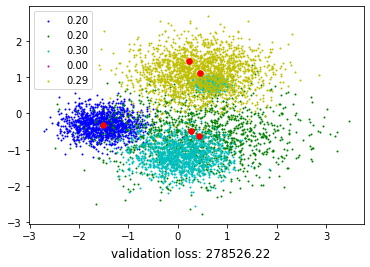

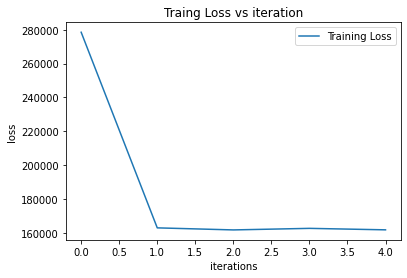

In [63]:
kList = [1, 2, 3, 4, 5]
bigKList = [5, 10, 15, 20, 25]
valLossList = []
for k in bigKList:
  lossList, mu, valLoss = train(k, data, dim, val_data)
  valLossList.append(valLoss)
#plot_loss(lossList)
plot_loss(valLossList)